In [219]:
import sys
sys.path.append('/Users/katieporter/Dropbox/Insight/CT/ct_private/')
import connect_fns_py3   # loading SQL connection functions written for this project
sys.path.append('/Users/katieporter/Dropbox/Insight/CT/ct_share/insight_fellowship')
import sql_queries  # loading sql query functions
import my_functions as fns
import importlib
import mysql.connector
# from os import chdir
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import time



import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
sns.set_context('poster')

#### reload functions 

In [220]:
importlib.reload(connect_fns_py3);
importlib.reload(sql_queries);
cnx = connect_fns_py3.connectMySQL();
cur = cnx.cursor();

Connected to Constant Therapy SQL


#### import list of target patients (no assisted sessions)

In [118]:
patient_list = pd.read_csv('sched_patient_list.csv')

#### import csv of target patients first/last timestamp 

In [164]:
timesall = pd.read_csv('allfirst_last_timestamp.csv')
# from datetime import datetime
# from datetime import timedelta

timesall['diffDays'] = (timesall['max(start_time)'].apply(fns.maketime_sec)- timesall['min(start_time)'].apply(fns.maketime_sec))/86400
timesall['diffHours'] = (timesall['max(start_time)'].apply(fns.maketime_sec)- timesall['min(start_time)'].apply(fns.maketime_sec))/3600
timesall['diffMin'] = (timesall['max(start_time)'].apply(fns.maketime_sec)- timesall['min(start_time)'].apply(fns.maketime_sec))/60
timesall['diffSec'] = timesall['max(start_time)'].apply(fns.maketime_sec)- timesall['min(start_time)'].apply(fns.maketime_sec)
timesall[11110:11120]

,patient_id,min(start_time),max(start_time),diffDays,diffHours,diffMin,diffSec
11110,54869,2015-12-30 16:49:42,2016-01-01 19:46:02,2.122454,50.938889,3056.333333,183380
11111,54870,2015-12-30 16:49:48,2015-12-31 07:05:45,0.594410,14.265833,855.950000,51357
11112,54876,2015-12-30 17:58:43,2016-01-01 12:16:22,1.762257,42.294167,2537.650000,152259
11113,54878,2015-12-30 18:57:58,2016-01-02 22:15:20,3.137060,75.289444,4517.366667,271042
11114,54885,2015-12-30 19:49:50,2016-01-02 14:15:21,2.767720,66.425278,3985.516667,239131
11115,54886,2015-12-30 21:09:29,2016-01-02 14:15:48,2.712720,65.105278,3906.316667,234379
11116,54892,2015-12-30 20:25:39,2015-12-30 21:30:47,0.045231,1.085556,65.133333,3908
11117,54893,2015-12-30 20:28:41,2015-12-30 20:28:41,0.000000,0.000000,0.000000,0
11118,54898,2015-12-30 21:36:31,2015-12-30 21:39:34,0.002118,0.050833,3.050000,183
11119,54900,2015-12-30 21:43:50,2016-01-02 18:30:39,2.865845,68.780278,4126.816667,247609


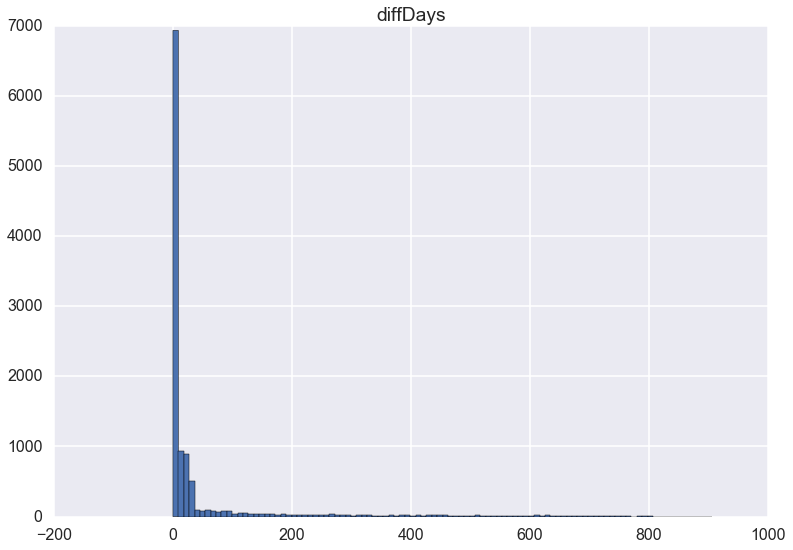

In [165]:
timesall.hist(column='diffDays', bins=100);

In [166]:
firstweek = timesall[timesall['diffDays'] <= 7]
firstmonth = timesall[timesall['diffDays'] <= 30]
firstday = timesall[timesall['diffDays'] <= 1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119231908>]], dtype=object)

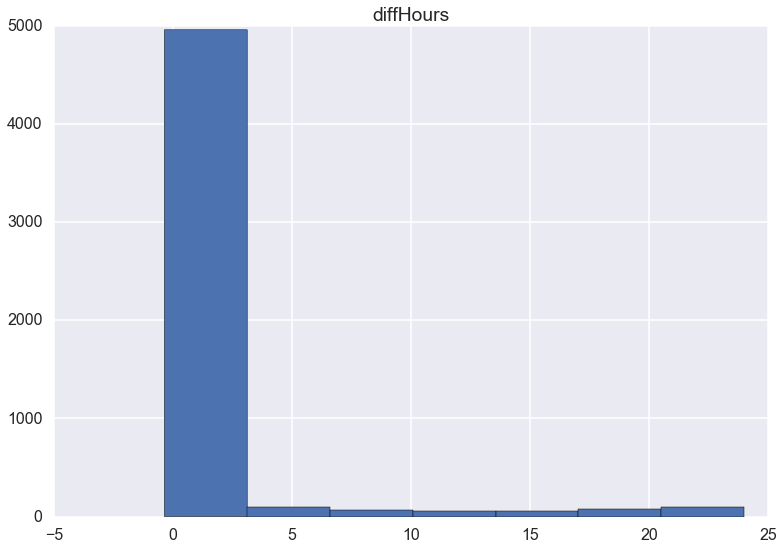

In [167]:
firstday.hist(column='diffHours', bins=7)

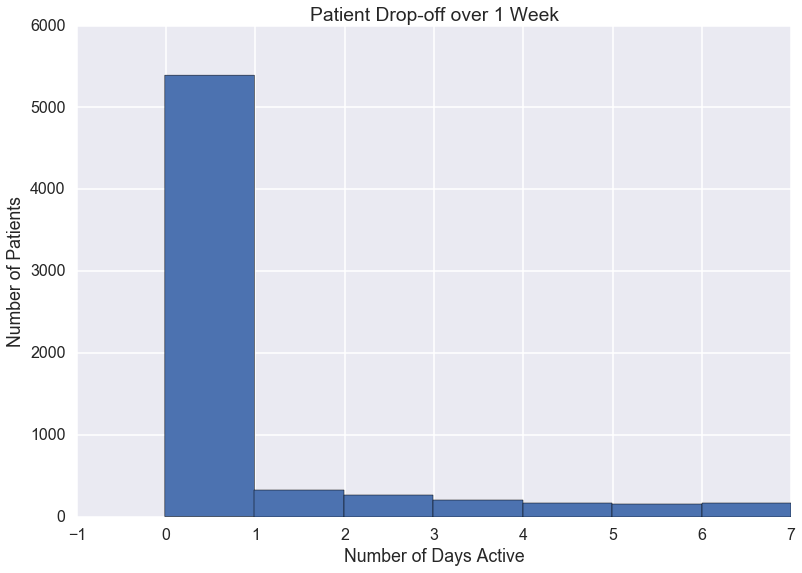

In [168]:
firstweek.hist(column='diffDays', bins=7);
ax = plt.xlabel("Number of Days Active")
plt.ylabel("Number of Patients");
plt.title("Patient Drop-off over 1 Week")
figDropoff = ax.get_figure()
figDropoff.savefig('week_dropoff.png')

#### for users who drop-off in the first day, get completed task ratio (completed / assigned) 

In [169]:
patient_nums_1day = np.array(firstday['patient_id'])
patient_nums_1day.shape

(5408,)

In [186]:
single_day_last5 = pd.DataFrame(columns=['patient_id', 'avg_duration', 'avg_accuracy', 'avg_latency', 'avg_ratio_completed'])
single_day_last5

,patient_id,avg_duration,avg_accuracy,avg_latency,avg_ratio_completed


In [221]:
# for i in patient_nums_1day[4941:]:
for i in patient_nums_1day:
    df = sql_queries.last_5_sessions(cur,i)
    avg_duration = df['duration'].mean()
    avg_accuracy = df['accuracy'].mean()
    avg_latency = df['latency'].mean()
    avg_ratio = df['completed_ratio'].mean()
    onedf = pd.DataFrame([[i,avg_duration,avg_accuracy,avg_latency,avg_ratio]],
                         columns=['patient_id', 'avg_duration', 'avg_accuracy', 'avg_latency', 'avg_ratio_completed'])
    single_day_last5 = single_day_last5.append(onedf, ignore_index=True)
    

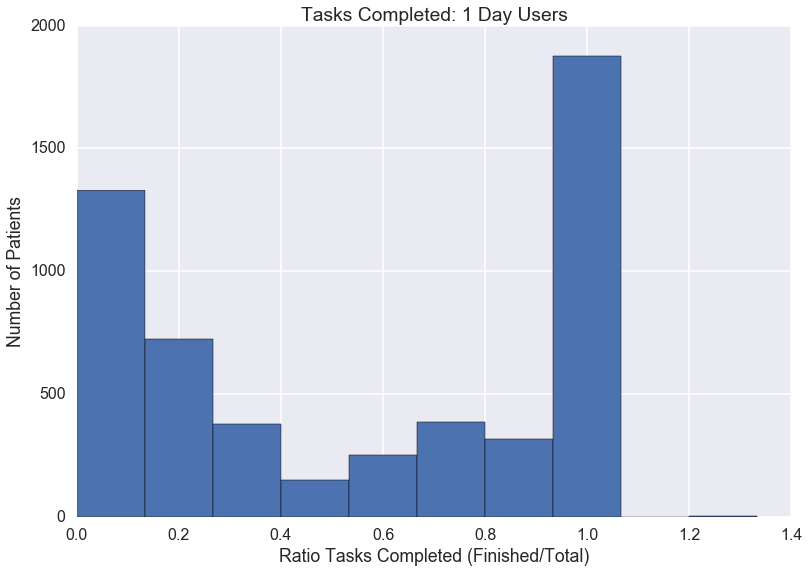

In [224]:
single_day_last5.hist(column='avg_ratio_completed');
ax = plt.xlabel("Ratio Tasks Completed (Finished/Total)")
plt.ylabel("Number of Patients");
plt.title("Tasks Completed: 1 Day Users")
figDropoff = ax.get_figure()
figDropoff.savefig('taskscompleted_1dayusers.png')

In [223]:
patient_nums_1day.shape

(5408,)

In [216]:
single_day_last5[4940:]

,patient_id,avg_duration,avg_accuracy,avg_latency,avg_ratio_completed
4940,50278,44,0.3,13.183333,0.4


In [218]:
patient_nums_1day[4941:]

array([50278, 50285, 50330, 50332, 50335, 50336, 50366, 50387, 50419,
       50425, 50427, 50457, 50484, 50487, 50488, 50501, 50502, 50503,
       50505, 50507, 50515, 50522, 50529, 50530, 50531, 50535, 50536,
       50564, 50578, 50583, 50584, 50608, 50618, 50620, 50629, 50630,
       50634, 50702, 50727, 50735, 50736, 50741, 50744, 50752, 50754,
       50756, 50796, 50797, 50810, 50852, 50856, 50862, 50893, 50904,
       50945, 50946, 50949, 50966, 50968, 50969, 50979, 50994, 51012,
       51022, 51038, 51047, 51050, 51060, 51062, 51066, 51071, 51074,
       51078, 51083, 51087, 51088, 51090, 51100, 51110, 51150, 51151,
       51188, 51189, 51191, 51192, 51201, 51203, 51206, 51207, 51209,
       51217, 51249, 51259, 51293, 51300, 51327, 51328, 51332, 51363,
       51376, 51377, 51378, 51380, 51387, 51388, 51389, 51392, 51398,
       51410, 51417, 51418, 51430, 51433, 51435, 51467, 51494, 51504,
       51515, 51525, 51539, 51546, 51556, 51558, 51584, 51587, 51588,
       51591, 51605,

In [143]:
onep = sql_queries.last_5_sessions(cur, 1039)
onep

,patient_id,duration,accuracy,latency,task_level,completed_ratio
0,1039,51,0.0000,49.830,5,0.0667
1,1039,464,0.9867,28.486,10,1.0000
2,1039,1170,0.6000,80.121,3,1.0000
3,1039,203,0.8000,10.873,1,1.0000
4,1039,823,0.6001,9.394,1,1.0000


In [152]:
out = onep['completed_ratio'].mean()

AttributeError: 'numpy.float64' object has no attribute 'type'

In [ ]:
# done with cursor
cur.close()             

# done with database
cnx.close()

In [ ]:
# def scheduled_patients(cur):
#     rstore = []
#     patient_num = [1039, 1254]
#     for i in patient_num:
#         cur.execute(("SELECT max(timestamp) FROM constant_therapy.responses where patient_id =({patient_num})").format(patient_num=i))
#         sleep(.5)
#         result = cur.fetchall()
#         r = [i[0] for i in result]
#         rstore = rstore + r
#         return rstore
# blah = scheduled_patients(cur)




# fig = plt.figure(figsize=(15, 15)) 
# bothData = pd.DataFrame({'Active' : activePatientRT, 
#                         'Inactive' : inactivePatientRT})
# plotL = bothData.plot(title="latency", )
# figL = plotL.get_figure()
# figL.savefig('latency2users.png')